# Implementing Hyperbolic SVM
`Drew Wilimitis`

In this notebook, I attempt to implement another foundational supervised learning algorithm in hyperbolic space to continue exploring how hyperbolic embeddings can be integrated with downstream machine learning tasks in order to fully exploit the representational capacity of hyperbolic geometry. <br>
<br>
I follow the approach recently outlined in "Large-margin classification in hyperbolic space". Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)

The original authors released a MATLAB implementation (https://github.com/hhcho/hyplinear) of hyperbolic support vector classifiers, which was then first implemented in python available through the excellent open-source repository - https://github.com/plumdeq/hsvm. <br>
<br>
Given these existing resources, the motivation behind this hyperbolic learning project is primarily intellectual curiosity. A secondary objective is to consolidate open-source implementations alongside the growing body of research and subsequent applications exploring hyperbolic analogues to machine learning methods.

## Algorithm Outline

Given data in the Poincare disk $\mathcal{B}^{d}$, consider supervised learning setting where we have training data instances with features $x^{j}$ and labels $y^{j}$: <br>
$$
\left\{\left(x^{(j)}, y^{(j)}\right)\right\}_{j=1}^{m}
$$ <br>
<br>
The basic steps in Hyperbolic SVM are: <br>
1. **Initialization step**: initialize weight vector $w$ that defines decision boundary <br>
2. **Optimization problem**: formulate standard euclidean max-margin optimization in hyperbolic space <br>
3. **Projected gradient descent**: iteratively solve for optimal $w$ via projected gradient descent in the hyperboloid model <br>
4. **Predict on new data samples**: use transitions between poincaré disk and hyperboloid models with decision boundary classification rules to perform supervised learning in hyperbolic space<br>

## Load libraries and helper functions

In [177]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

## Poincaré Disk vs. Hyperboloid Model

In [178]:
# numerical stability
eps = 1e-6

# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# compute symmetric poincare distance matrix
def poincare_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array from poincare disk to hyperboloid
def poincare_pts_to_hyperboloid(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    mink_pts[:, 1] = 2/(1 - r**2 + eps) * Y[:, 0]
    mink_pts[:, 2] = 2/(1 - r**2 + eps) * Y[:, 1]
    return mink_pts

# convert single point to hyperboloid
def poincare_pt_to_hyperboloid(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    mink_pt[1] = 2/(1 - r**2 + eps) * y[0]
    mink_pt[2] = 2/(1 - r**2 + eps) * y[1]
    return mink_pt

In [179]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    return u[0]*v[0] - np.dot(u[1:], v[1:]) 

# hyperboloid distance function
def hyperboloid_dist(u, v):
    dist = np.arccosh(-1*minkowski_dot(u, v))
    if np.isnan(dist):
        #print('Hyperboloid dist returned nan value')
        return eps
    else:
        return dist

# compute symmetric hyperboloid distance matrix
def hyperboloid_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = hyperboloid_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array to poincare disk
def hyperboloid_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 1] / (X[:, 0]+1)
    poincare_pts[:, 1] = X[:, 2] / (X[:, 0]+1)
    return poincare_pts

def proj(theta,eps=1e-4):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

# convert single point to poincare
def hyperboloid_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[1] / (x[0]+1)
    poincare_pt[1] = x[2] / (x[0]+1)
    return proj(poincare_pt)

In [180]:
# helper function to generate samples
def generate_data(n, radius=0.7, hyper=False):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    if hyper:
        return poincare_pts_to_hyperboloid(init_data)
    else:
        return init_data

In [181]:
# test hyperboloid bilinear form condition
data = generate_data(20)
poinc_pts = data
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(minkowski_dot(pt, pt), 1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


## Gradient descent

$$
\begin{array}{c}{\text { minimize }_{w \in \mathbb{R}^{n+1}}-\frac{1}{2} w * w+C \sum_{j=1}^{m} \max \left(0, \sinh ^{-1}(1)-\sinh ^{-1}\left(y^{(j)}\left(w * x^{(j)}\right)\right)\right)} \\ {\text { subject to } w * w<0}\end{array}
$$

Projected gradient descent: project $y$ onto set $X$:<br>
$$
\Pi_{X}(y)=\underset{x \in X}{\operatorname{argmin}} \frac{1}{2}\|x-y\|_{2}^{2}
$$

In [182]:
# sample hyperboloid data, euclidean hyperplane, labels for testing
from sklearn.svm import LinearSVC
X = generate_data(10, hyper=True)
X[:5]
y = np.arange(10) % 2
y = 2*y-1
y[:5]
X.shape
lin_svm = LinearSVC()
w = lin_svm.fit(X, y).coef_[0]
w

array([[ 3.12868509e+00, -1.37031394e+00, -2.62886177e+00],
       [ 3.01410164e+00,  1.58324554e+00,  2.36180996e+00],
       [ 2.37891362e+00,  2.15852458e+00,  2.24390498e-03],
       [ 2.21412027e+00, -1.25662251e+00, -1.52421510e+00],
       [ 2.36186708e+00, -2.13698809e+00, -1.08172869e-01]])

array([-1,  1, -1,  1, -1], dtype=int32)

(10, 3)

array([-0.08015618,  0.19203573, -0.00462424])

In [183]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    """
    Compute minkowski inner product (assume u,v are single points for now)
    """
    return u[0]*v[0] - np.dot(u[1:], v[1:])

# verify mink_prod(x, x) = 1
if np.array([np.allclose(minkowski_dot(pt, pt), 1) for pt in X]).all():
    print('Test passed!')

def loss_fn(w, X, y, C=1.0):
    """
    Compute loss function for HSVM maximum margin formulation
    """
    margin_loss = -1/2 * minkowski_dot(w, w)
    misclass_loss = np.arcsinh(1) - np.arcsinh(y *[minkowski_dot(w, x) for x in X])
    return margin_loss + C*np.sum(np.where(misclass_loss > 0, misclass_loss, 0))

loss_fn(w, X, y)

Test passed!


10.240370581582322

In [184]:
def grad_fn(w, X, y, C=1.0):
    """
    Solve for gradient w.r.t w for loss function L(w, x, y)
    """
    #if len(y.shape) < 2:
    #    y = y.reshape(-1, 1)
    grad_margin = np.hstack((-w[0], w[1:]))
    z = y*np.array([minkowski_dot(w, x) for x in X])
    misclass = (np.arcsinh(1) - np.arcsinh(z)) > 0
    arcsinh_term = -1/np.sqrt(z**2 + 1)
    mink_prod_term = y.reshape(-1,1)*np.hstack((X[:, 0].reshape(-1,1), -1*X[:, 1:]))
    grad_misclass = misclass.reshape(-1,1) * arcsinh_term.reshape(-1,1) * mink_prod_term
    grad_w = grad_margin + C*np.sum(grad_misclass, axis=0)
    return grad_w

grad_fn(w, X, y, 1)

array([ 3.17028533,  7.78054732, -2.00921741])

In [185]:
def is_feasible(w):
    norm_cond = minkowski_dot(w, w) < 0
    return norm_cond
is_feasible(np.array([1, 1, 1]))
is_feasible(np.array([3, 1, 1]))

import scipy as sp
def proj_boundary(w, alpha, eps=1e-2):
    proj_w = w.copy()
    proj_w[1:] = (1 + alpha)*proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:]**2) - eps)
    return proj_w

True

False

In [186]:
w = np.array([0.75208173, 0.48544325, 0.00116963])
alpha_range = np.arange(0, 1, 0.1)
proj_dists = []
if not is_feasible(w):
    for alpha in alpha_range:
        proj_w = proj_boundary(w, alpha)
        proj_dist = np.sqrt(np.sum((w - proj_w)**2, axis=0))
        print('Euclidean dist(w, proj_w) = ', proj_dist)
        proj_dists.append(proj_dist)
else:
    print('No projection needed')

Euclidean dist(w, proj_w) =  0.2770485553638496
Euclidean dist(w, proj_w) =  0.23266039846150713
Euclidean dist(w, proj_w) =  0.20292832050939616
Euclidean dist(w, proj_w) =  0.1945357323403955
Euclidean dist(w, proj_w) =  0.2099573807027575
Euclidean dist(w, proj_w) =  0.24467045343179786
Euclidean dist(w, proj_w) =  0.2918327070010523
Euclidean dist(w, proj_w) =  0.3463714362267098
Euclidean dist(w, proj_w) =  0.40530357746867424
Euclidean dist(w, proj_w) =  0.4669576344622056


In [187]:
def alpha_search(w):
    res = sp.optimize.minimize_scalar(lambda alpha: np.sum((proj_boundary(w, alpha) - w)**2))
    alpha = res.x
    return alpha
alpha_opt = alpha_search(w)
proj_w = proj_boundary(w, alpha_opt)
alpha_opt_dist = np.sqrt(np.sum((w - proj_w)**2, axis=0))
print('Euclidean dist(w, proj_w) = ', alpha_opt_dist)
proj_dists.append(alpha_opt_dist)

Euclidean dist(w, proj_w) =  0.1942506242347344


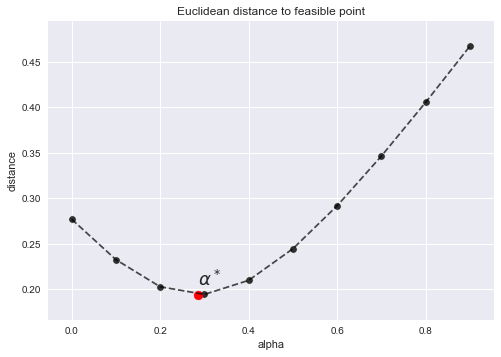

In [188]:
plt.style.use('seaborn')
plt.scatter(alpha_range, proj_dists[:-1], c='black', alpha=0.8, edgecolors='w', linewidth=1, s=60)
plt.scatter(alpha_opt, proj_dists[-1], c='red', s=80)
plt.text(alpha_opt, proj_dists[-1]+0.01, s=r'$\alpha^*$', size=18)
plt.plot(alpha_range, proj_dists[:-1], c='black', linestyle='--', alpha=0.7)
plt.title('Euclidean distance to feasible point')
plt.xlabel('alpha')
plt.ylabel('distance')
plt.show();

In [189]:
import logging
logging.basicConfig(level=logging.INFO)
#logger = logging.getLogger(__name__)
def train_hsvm(w, X, y, C, num_epochs, lr, batch_size, max_lr_attempts, early_stopping, verbose):
    num_samples = len(y)
    y = 2*y - 1
    early_stop_count = 0
    lr_attempts = 0
    init_w = w
    min_loss = np.inf
    best_w = init_w
    if not is_feasible(init_w):
        init_w = proj_boundary(init_w, alpha=0.01)
    if is_feasible(init_w):
        w_new = init_w
        init_loss = loss_fn(init_w, X, y, C)
        for j in range(num_epochs):
            start = time.time()
            current_loss = 0
            shuffle_index = np.random.permutation(num_samples)
            for i in range(0, num_samples, batch_size):
                Xj = X[shuffle_index[i:i+batch_size]]
                yj = y[shuffle_index[i:i+batch_size]]
                grad_w = grad_fn(w_new, Xj, yj, C)
                w_new = w_new - lr*grad_w
                # if not in feasible region, need to use projection
                if not is_feasible(w_new):
                    # solve optimization problem for nearest feasible point
                    alpha_opt = alpha_search(w_new)
                    # project w to feasible sub-space
                    w_new = proj_boundary(w_new, alpha_opt)
                current_loss += loss_fn(w_new, Xj, yj, C)
            current_loss = current_loss / num_samples
            if current_loss < min_loss:
                min_loss = current_loss
                best_w = w_new
            else:
                early_stop_count += 1
                if early_stop_count >= early_stopping:
                    #print('Exiting early: no decrease for ' + str(early_stopping) + ' rounds')
                    break
            if verbose:
                #logger.debug('loss {}'.format(sum_loss))
                print('COMPLETED EPOCH ', j+1)
                print('-------- LOSS: ', current_loss)
                #print('---------- total seconds: ', time.time() - start)
            if lr_attempts < max_lr_attempts:
                if init_loss < min_loss:
                    lr_attempts += 1
                    new_lr = lr / 10
                    print('Retry attempt # ' + str(lr_attempts) + ' with reduced lr: ' + str(new_lr))
                    w_new = init_w
                    early_stop_count = 0
    #print('Error: unable to begin training with initial w (weights)')
    return best_w

In [190]:
from sklearn.svm import LinearSVC

class LinearHSVM():
    """
    Hyperbolic support vector classification model trained in the hyperboloid (Lorentz) model 
    with an iterative, projected gradient descent method
    
    """
    
    def __init__(self, C=1.0, num_epochs=50, lr=0.001, tol=1e-8, batch_size=20, 
                 early_stopping=10, max_retries = 3, verbose=False):
        self.C = C
        self.num_epochs = num_epochs
        self.tol = tol
        self.verbose = verbose
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.lr = lr
        self.max_retries = max_retries
        
    def init_weights(self, X, y):
        """
        Initialize w (weights) with the coefficients found from applying
        standard LinearSVC in the ambient Euclidean space
        
        """
        # fit linear svm using scikit-learn classifier
        linear_svm = LinearSVC(fit_intercept=False, loss='hinge')
        self.init_coef = linear_svm.fit(X, y).coef_[0]
        # initialize with learned weights
        #if is_feasible(linear_svm_w):
            #print('starting with linsvm weights')
        #    self.init_coef = linear_svm_w
        #else:
            #print('attempting to project linsvm weights')
         #   proj_svm_coef = proj_boundary(linear_svm_w, alpha_search(linear_svm_w))
         #   if is_feasible(proj_svm_coef):
         #       self.init_coef = proj_svm_coef
         #   else:
                #print('using random initialization')
          #      w = np.random.randn(3, )
          #      if is_feasible(w):
          #          self.init_coef = w
          #      else:
          #         self.init_coef = proj_boundary(w, alpha_search(w))
            
        # correct for possible labeling discrepancy (binary labels (0,1) vs. labels (-1, 1))
        #svm.decision_function(x1.reshape(1,-1))
        #self.init_coef[0] = -linear_svm.coef_[0][0]
    
    def fit(self, X, y):
        """
        Train linear HSVM model for input data X, labels y
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples, 1)
        """
        self.init_weights(X, y)
        classes = np.unique(y)
        self.class_labels_ = {'neg_class': np.min(classes), 'pos_class': np.max(classes)}
        self.coef_ = train_hsvm(self.init_coef, X, y, self.C, 
                                self.num_epochs, self.lr, self.batch_size,
                                early_stopping=self.early_stopping,
                                max_lr_attempts=self.max_retries, verbose=self.verbose)
        return self

    def predict(self, X):
        """
        Predict class labels with hyperbolic linear decision function
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        """
        y_pred = np.zeros((X.shape[0], ))
        vals = np.array([minkowski_dot(self.coef_, x) for x in X])
        y_pred[vals < 0] = self.class_labels_['neg_class']
        y_pred[vals >= 0] = self.class_labels_['pos_class']
        return y_pred
    
    def score(self, X, y):
        """
        Return mean accuracy evaluated on X, y
        """
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)
    
    def decision_function(self, X):
        """
        Evaluate minkowski inner product between weights and input data
        """
        vals = np.array([minkowski_dot(self.coef_, x) for x in X])
        return vals


## Basic testing and visualizing decision boundaries

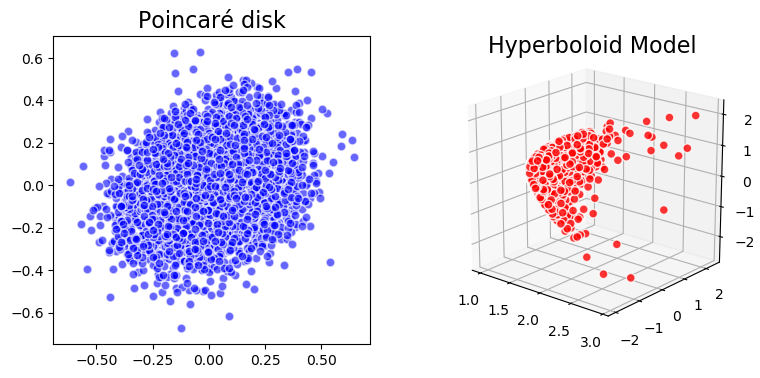

In [191]:
from sklearn.datasets import make_blobs
plt.style.use('default')
centers = [[-0.1,-0.1], [0.1, 0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.15)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='white', linewidth=1, alpha=0.6);

ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

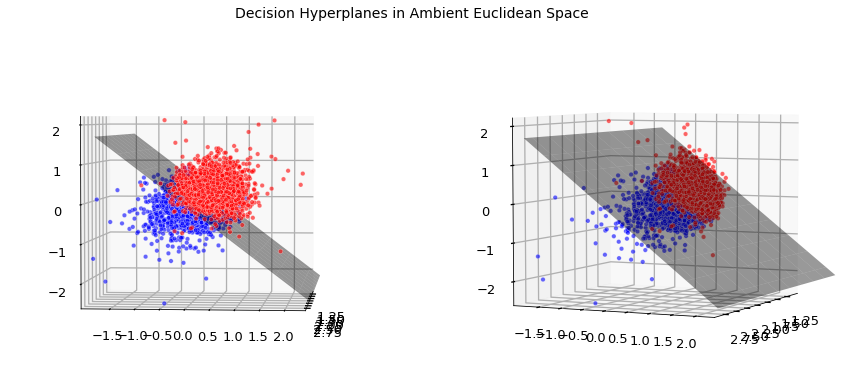

In [192]:
from sklearn.svm import LinearSVC
hsvm_clf = LinearHSVM(early_stopping=1, C=0.1, num_epochs=20, lr=0.00001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
hsvm_clf.coef_
plt.style.use('seaborn-talk')
X = mink_pts
z = lambda x,y: (-hsvm_clf.coef_[0]*x-hsvm_clf.coef_[1]*y) / hsvm_clf.coef_[2]
x_range = np.linspace(0, 3, 20)
y_range = np.linspace(-1.8, 2.5, 20)
x,y = np.meshgrid(x_range, y_range)

%matplotlib inline
import matplotlib

fig = plt.figure(figsize=(15,6))
ax  = fig.add_subplot(121, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(3, 5)

ax  = fig.add_subplot(122, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(5, 25)
plt.suptitle(t='Decision Hyperplanes in Ambient Euclidean Space', size=14)
plt.show();

In [193]:
# fit hsvm on another simple test clustering dataset
centers = [[-0.41,-0.40], [-0.1, -0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.05)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
hsvm_clf = LinearHSVM(early_stopping=10, C=1, num_epochs=30, lr=0.01, verbose=False)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
# get approximate intersection of hyperplane and L2
L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
L2[inter].shape
hsvm_clf.score(mink_pts, labels)

(185, 3)

1.0

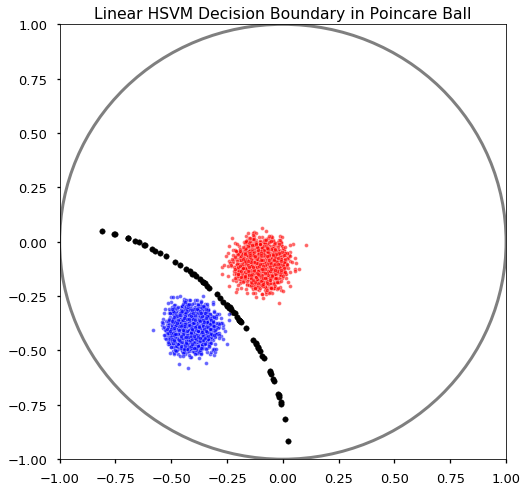

In [194]:
# plot decision boundary in poincare ball
dec_bound = L2[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
plt.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w', s=15)
plt.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w', s=15)
plt.xlim([-1.,1.])
plt.ylim([-1.,1.])
plt.title('Linear HSVM Decision Boundary in Poincare Ball')
plt.show();

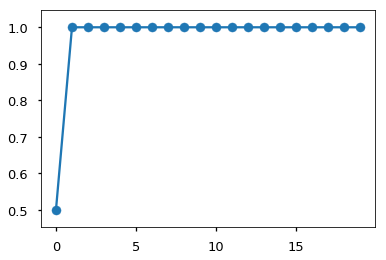

In [195]:
centers = [[-0.41,-0.40], [-0.1, -0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.05)
data = X# / (np.max(norm(X, axis=1)) - 1e-3)
mink_pts = poincare_pts_to_hyperboloid(data)
scores = []
weights = []
for i in np.arange(0, 20):
    hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=2*i, lr=0.01, verbose=False)
    w = hsvm_clf.fit(mink_pts, labels).coef_
    scores.append(hsvm_clf.score(mink_pts, labels))
    weights.append(hsvm_clf.coef_)

plt.scatter(np.arange(0, 20), scores)
plt.plot(scores);

False


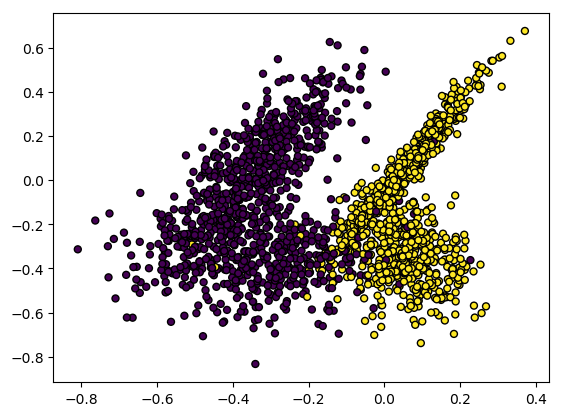

In [196]:
from sklearn.datasets import make_moons, make_classification
plt.style.use('default')
X, labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                n_samples=2000, scale=.2, shift=-0.7)
data = X
data[(norm(X, axis=1) > 1)] = data[(norm(X, axis=1) > 1)] / (np.max(norm(X, axis=1)))
print((norm(data, axis=1) > 1).any())
mink_pts = poincare_pts_to_hyperboloid(data)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=labels, s=25, edgecolor='k');

In [197]:
hsvm_clf = LinearHSVM(early_stopping=10, C=1, num_epochs=50, lr=0.01, verbose=True)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
L2[inter].shape
hsvm_clf.score(mink_pts, labels)

COMPLETED EPOCH  1
-------- LOSS:  1.7786068517603306
COMPLETED EPOCH  2
-------- LOSS:  0.5219090886884642
COMPLETED EPOCH  3
-------- LOSS:  0.32053929819961857
COMPLETED EPOCH  4
-------- LOSS:  0.3217266617356545
COMPLETED EPOCH  5
-------- LOSS:  0.3202708088298202
COMPLETED EPOCH  6
-------- LOSS:  0.3215518718557065
COMPLETED EPOCH  7
-------- LOSS:  0.3197120440873307
COMPLETED EPOCH  8
-------- LOSS:  0.3206566265386444
COMPLETED EPOCH  9
-------- LOSS:  0.3213120893654815
COMPLETED EPOCH  10
-------- LOSS:  0.32070473576293307
COMPLETED EPOCH  11
-------- LOSS:  0.32033865909302456
COMPLETED EPOCH  12
-------- LOSS:  0.32046285179753875
COMPLETED EPOCH  13
-------- LOSS:  0.322152393760586
COMPLETED EPOCH  14
-------- LOSS:  0.3213476294520474


(175, 3)

0.9585

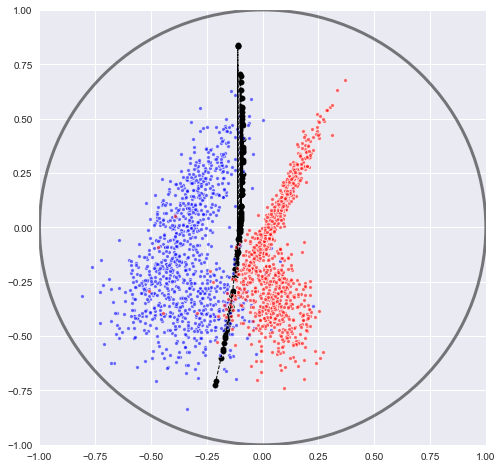

In [214]:
from scipy.interpolate import interp1d
dec_bound = L2[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
%matplotlib inline
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
X = data
plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
x=ball_dec[:,0]
y=ball_dec[:,1]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='slinear')
y_smooth=f(x_new)
plt.plot(x_new,y_smooth, color='black', linewidth=1, linestyle='--')
plt.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w', linewidths=1, s=15)
plt.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w', linewidths=1, s=15)
plt.xlim([-1.,1.])
plt.ylim([-1.,1.])
plt.show();

# Evaluating LinearHSVM<br>

I'll attempt to evaluate this implementation of LinearHSVM on the three test cases proposed in the original publication and available online through [1]. <br>
<br>
Ex. 1) Synthetically generated gaussian mixture data

In [215]:
# project back to within poincare ball to avoid instability
def proj_ball(X, eps=1e-3):
    out_pts = norm(X, axis=1) > 1
    num_pts = np.sum(out_pts)
    X[out_pts] = X[out_pts] / norm(X[out_pts], axis=0) - np.repeat(eps, num_pts).reshape(-1,1)
    return X

# read in matlab data files from: https://github.com/hhcho/hyplinear
# and https://github.com/plumdeq/hsvm
def get_gaussian_data(path):
    # load .mat files with gaussian datasets
    data = sp.io.loadmat(path)
    X, y = data['B'], data['label'].ravel().astype(np.int)
    class_labels = np.unique(y)
    #print('Loaded data X with shape: ' + str(X.shape) + ' ,labels Y with ' + str(len(class_labels)) + ' classes.')
    # if not in poincare disk, project points within the disk
    if (norm(X, axis=1) > 1).any():
        out_pts = norm(X, axis=1) > 1
        num_pts = np.sum(out_pts)
        X[out_pts] = X[out_pts] / norm(X[out_pts], axis=0) - np.repeat(eps, num_pts).reshape(-1,1)
    return X, y

In [216]:
# read files from local path
import os
import scipy.io as sio
path = 'C:/Users/dreww/Desktop/hyplinear-master/data/gaussian'
mat_files = []
for f in os.listdir(path):
    mat_files.append(path + '/' + f)

<br>
To train LinearHSVM on Gaussian clusterings and assess prediction performance with multiclass datasets, I first build a rather inelegant procedure below to perform each of the required classification models one vs. rest (One vs. All) classification.

In [217]:
# read data, binarize and train One vs. Rest classifier with input label
def eval_ovr_gaussian(path, n_trials=5, n_splits=1, class_label=1):
    X,labels = get_gaussian_data(path)
    shuffle_index = np.random.permutation(len(labels))
    X = X[shuffle_index]
    X = poincare_pts_to_hyperboloid(X)
    labels_binary = label_binarize(labels, classes=[1, 2, 3, 4])
    y = labels_binary[:, class_label-1]
    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=None)
    results_dict = {}
    roc_scores = []
    acc_scores = []
    recall_scores = []
    precision_scores = []
    aucpr_scores = []
    for k in range(n_trials):
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            hsvm = LinearHSVM(early_stopping=1, C=5, num_epochs=17, lr=0.00001, batch_size=10, verbose=False)
            hsvm.fit(X_train, y_train)
            pred_scores = hsvm.decision_function(X_test)
            roc_scores.append(roc_auc_score(y_test, pred_scores))
            acc_scores.append(hsvm.score(X_test, y_test))
            precision, recall, _ = precision_recall_curve(y_test, pred_scores)
            recall_scores.append(recall)
            precision_scores.append(precision)
            aucpr_scores.append(auc(recall, precision))
    results_dict['roc'] = roc_scores
    results_dict['auc_pr'] = aucpr_scores
    results_dict['acc'] = acc_scores
    results_dict['recall'] = recall_scores
    results_dict['precision'] = precision_scores
    return results_dict

In [218]:
test_results = []
for file in mat_files:
    trial_dict = eval_ovr_gaussian(file, class_label=1, n_trials=5)
    test_results.append(trial_dict)

In [213]:
def eval_metrics(clf_results):
    final_scores = {}
    final_scores['mean_roc'] = np.mean([sub_dict['roc'] for sub_dict in clf_results])
    final_scores['mean_aucpr'] = np.mean([sub_dict['auc_pr'] for sub_dict in clf_results])
    final_scores['mean_acc'] = np.mean([sub_dict['acc'] for sub_dict in clf_results])
    final_scores['recall'] = [sub_dict['recall'] for sub_dict in clf_results]
    final_scores['precision'] = [sub_dict['precision'] for sub_dict in clf_results]
    return final_scores

Class 1:  [('mean_roc', 0.49406826666666664), ('mean_aucpr', 0.253246046848984), ('mean_acc', 0.6882)]
Class 2:  [('mean_roc', 0.4994565333333333), ('mean_aucpr', 0.2581424948905933), ('mean_acc', 0.69466)]
Class 3:  [('mean_roc', 0.49723306666666667), ('mean_aucpr', 0.25894047694583594), ('mean_acc', 0.69977)]
Class 4:  [('mean_roc', 0.49914986666666666), ('mean_aucpr', 0.2605528854549973), ('mean_acc', 0.6977599999999999)]


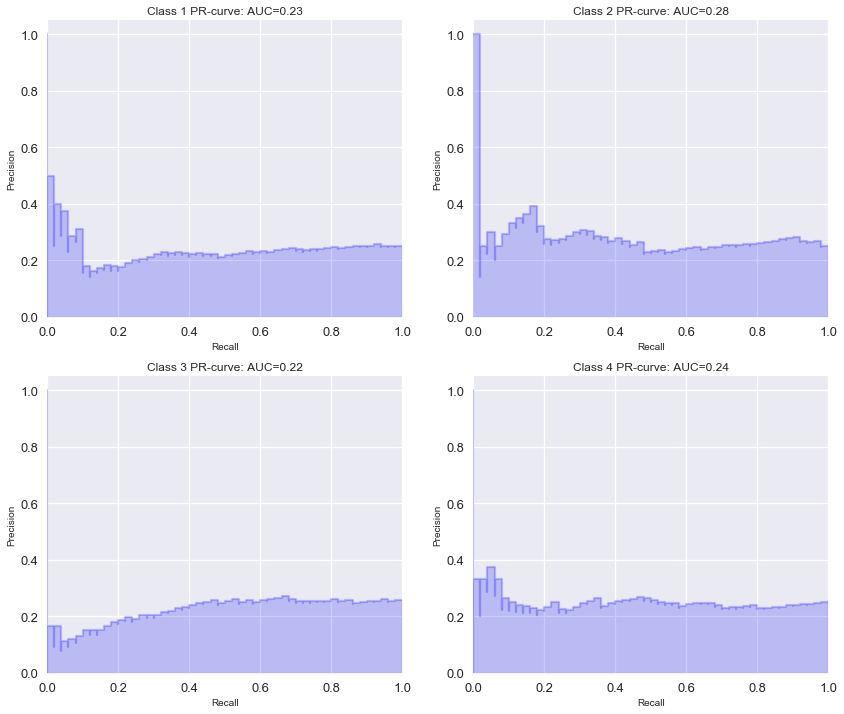

In [212]:
unique_classes = [1,2,3,4]
plt.style.use('seaborn-talk')
plt.figure(figsize=(14, 12))
for clabel in unique_classes:
    test_results = []
    for file in mat_files:
        trial_dict = eval_ovr_gaussian(file, class_label=clabel, n_trials=5)
        test_results.append(trial_dict)
        
    final_scores = eval_metrics(test_results)
    recall_1 = final_scores['recall'][0]
    precision_1 = final_scores['precision'][0]
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    _ = plt.subplot(2, 2, clabel)
    _ = plt.step(recall_1[1], precision_1[1], color='b', alpha=0.2, where='post');
    _ = plt.fill_between(recall_1[1], precision_1[1], alpha=0.2, color='b', **step_kwargs);
    _ = plt.xlabel('Recall', size=10);
    _ = plt.ylabel('Precision', size=10);
    _ = plt.ylim([0.0, 1.05]);
    _ = plt.xlim([0.0, 1.0]);
    _ = plt.title('Class ' + str(clabel) + ' PR-curve: AUC={0:0.2f}'.format(auc(recall_1[1], precision_1[1])),
                 size=12)
    print('Class ' + str(clabel) + ': ', list(final_scores.items())[:3])
plt.show();

## Gaussian clusters and hyperbolic decision boundary

In [133]:
# convert array or list [a, b] to complex number a+bi
def to_complex(xi):
    return np.complex(xi[0], xi[1])

# parametrized hyperbolic line with distance s from point z0 in direction gamma
def hyp_line(s, gamma, z0):
    if not isinstance(z0,complex):
        z0 = to_complex(z0)
    if not isinstance(gamma, complex):
        gamma = to_complex(gamma)
    return (gamma * np.tanh(s/2) + z0) / (np.conj(z0) * gamma * np.tanh(s/2) + 1)

def plot_hyp_line(dist, gamma, z0, color = 'black', whole_line = False, z0_label=None, endpts = False):
    ax = plt.gca()
    if np.all(gamma == 0):
        ax.scatter(np.real(z0), np.imag(z0), s=40, alpha=1, c='black');
        ax.text(np.real(z0)-0.05, np.imag(z0)+0.05, z0_label, size=16);
        return
    gamma = gamma / norm(gamma)
    pts = []
    for r in np.arange(0, dist, 0.05):
        zj = hyp_line(r, gamma, z0)
        pts.append(zj)
        if whole_line:
            zj_flip = hyp_line(r, -1*gamma, z0)
            pts.append(zj_flip)
    pts = np.array(pts)
    ax.scatter(np.real(pts), np.imag(pts), s=25, alpha=1, c=color)
    ax.scatter(np.real(z0), np.imag(z0), s=25, alpha=1, c=color);

Class 0 roc auc score:  0.2353
Class 0 accuracy score:  0.7225
Class 1 roc auc score:  0.1994
Class 1 accuracy score:  0.75
Class 2 roc auc score:  0.18263333333333334
Class 2 accuracy score:  0.6075
Class 3 roc auc score:  0.35996666666666666
Class 3 accuracy score:  0.74


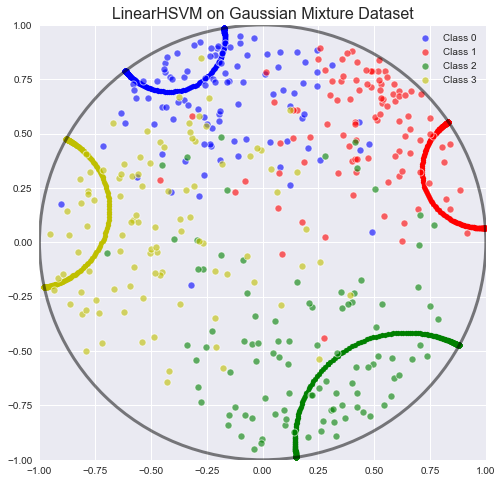

In [153]:
def plot_gaussian(X, labels):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(8,8))
    colors = ['b', 'r', 'g', 'y']
    y_binary = label_binarize(labels, classes=[1, 2, 3, 4])
    for i in range(y_binary.shape[1]):
        hsvm_clf = LinearHSVM(early_stopping=1, C=10, num_epochs=28, lr=0.00001, verbose=False, batch_size=12)
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X), y_binary[:, i])
        w = hsvm_clf.coef_.copy()
        pred_scores = hsvm_clf.decision_function(poincare_pts_to_hyperboloid(X))
        print('Class ' + str(i) + ' roc auc score: ', roc_auc_score(y_binary[:, i], pred_scores))
        print('Class ' + str(i) + ' accuracy score: ', hsvm_clf.score(poincare_pts_to_hyperboloid(X), y_binary[:, i]))
        L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
        inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-3
        dec_bound = L2[inter]
        ball_dec = hyperboloid_pts_to_poincare(dec_bound)
        ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
        gamma = np.complex(1,1)
        z0 = to_complex(-1*ball_dec[np.argmin(norm(ball_dec, axis=1))])
        plot_hyp_line(10, gamma, z0, z0_label=str(i+1), color = colors[i], whole_line=True);
        #plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=30, color='black')
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    for i in range(y_binary.shape[1]):
        plt.scatter(X[(labels==i+1),0], X[(labels==i+1),1], c=colors[i], label='Class ' + str(i),
                    alpha=0.6, edgecolors='w', linewidths=1, s=50)
    plt.xlim([-1.,1.])
    plt.ylim([-1.,1.])
    plt.legend()
    plt.title('LinearHSVM on Gaussian Mixture Dataset', size=16)
    plt.show();
X, y = get_gaussian_data(mat_files[93])
plot_gaussian(X, y);

## Resources

**[1]**. "Large-margin classification in hyperbolic space" . Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)<br>
**[2]**. https://github.com/plumdeq/hsvm <br>